### 1.Import libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

### 2.Load & explore dataset

In [53]:
df = pd.read_csv('/Users/joeljoseph/Downloads/housing.csv')

In [54]:
df.shape

(20640, 10)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [56]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### 3.Checking Distribution & outliers

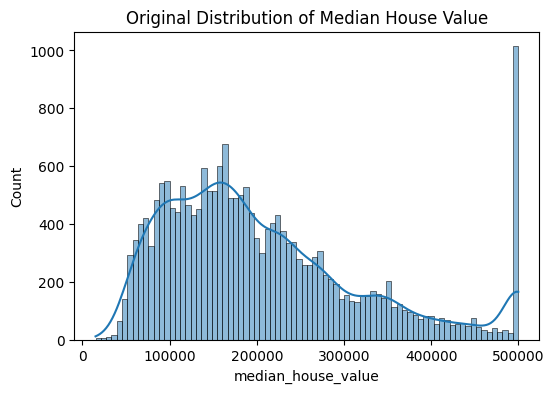

In [57]:
plt.figure(figsize=(6, 4))
sns.histplot(df['median_house_value'], bins=80, kde=True)
plt.title('Original Distribution of Median House Value')
plt.show()

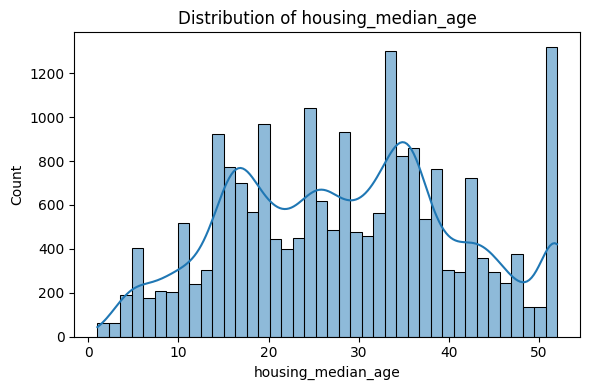

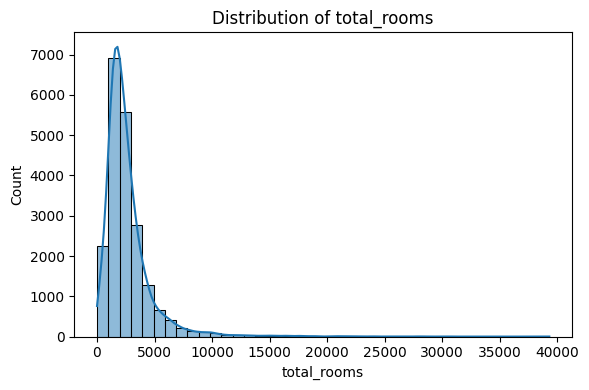

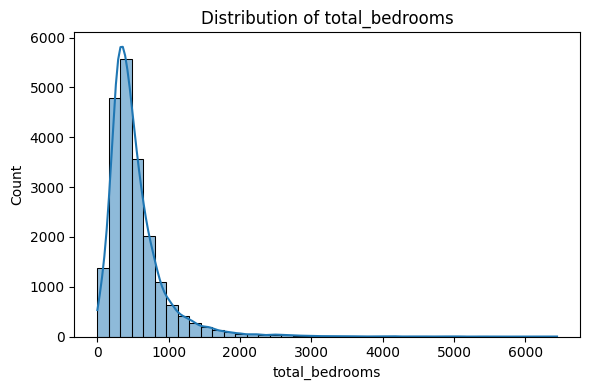

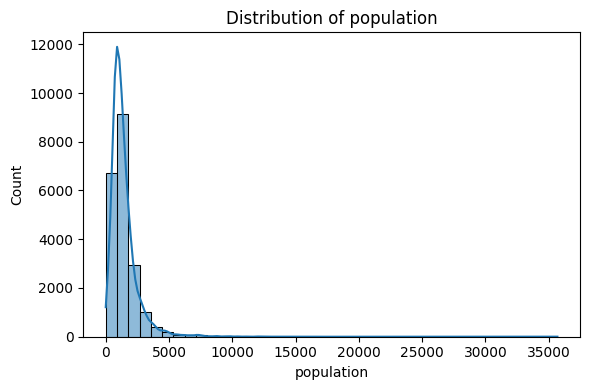

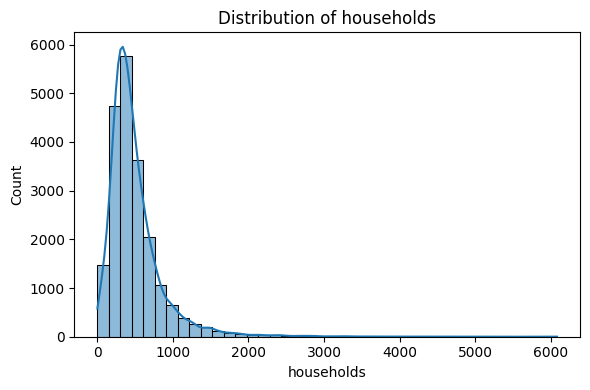

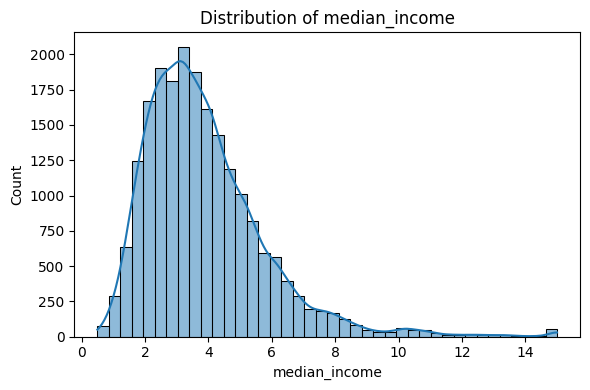

In [58]:
excluded_cols = ['median_house_value', 'latitude', 'longitude']

for col in df.select_dtypes(include=[np.number]).columns:
    if col not in excluded_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], bins=40, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

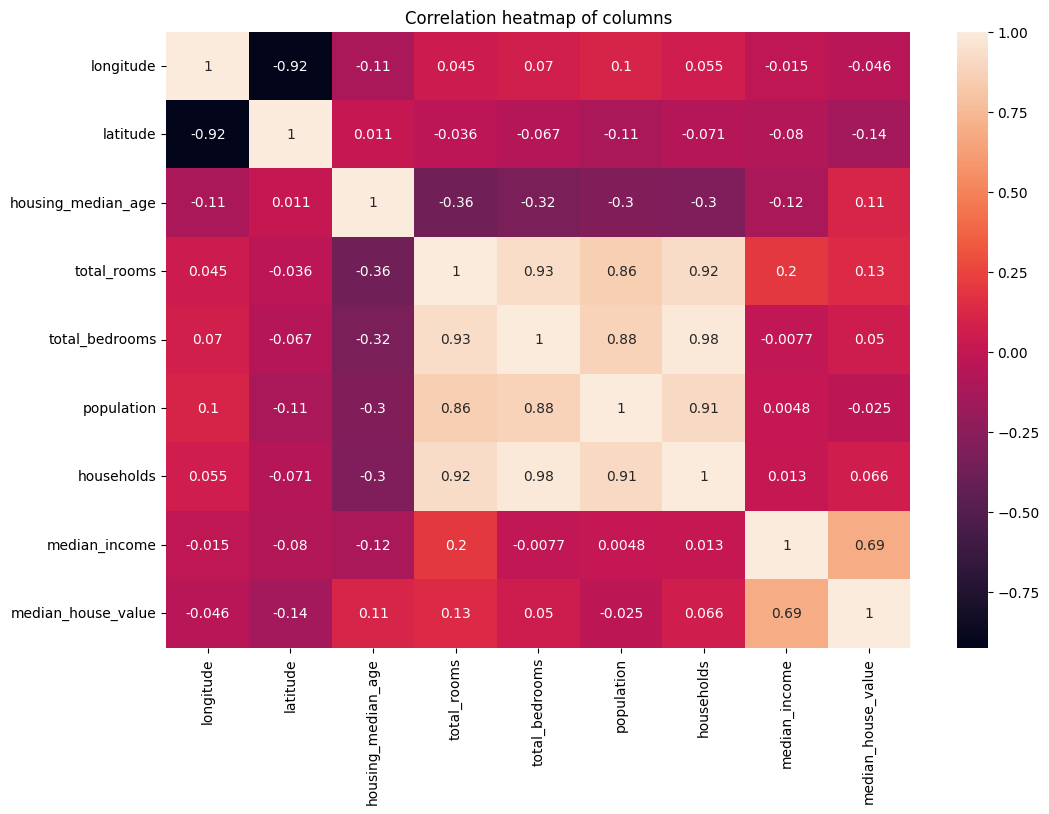

In [59]:
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(df.drop(columns=['ocean_proximity']).corr(), annot=True)
plt.title('Correlation heatmap of columns')
plt.show()


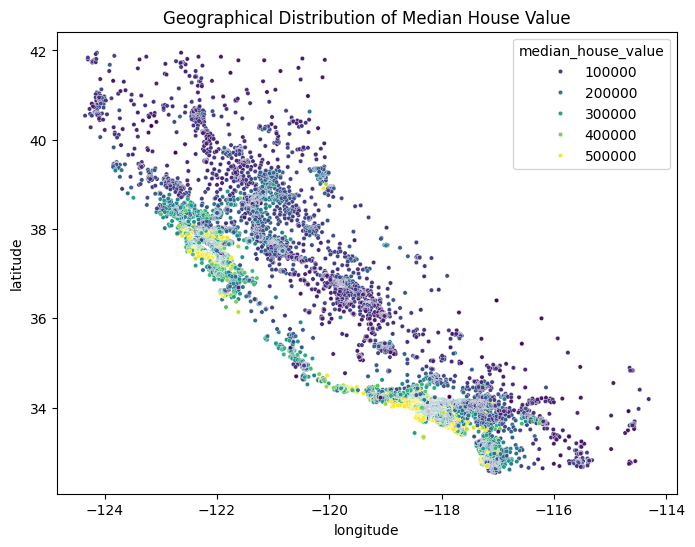

In [60]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='median_house_value', palette='viridis', s=10)
plt.title('Geographical Distribution of Median House Value')
plt.show()

### 4.Feature engineering

In [61]:
kmeans_temp = KMeans(n_clusters=5, random_state=42)
df['region_cluster'] = kmeans_temp.fit_predict(df[['latitude', 'longitude']])

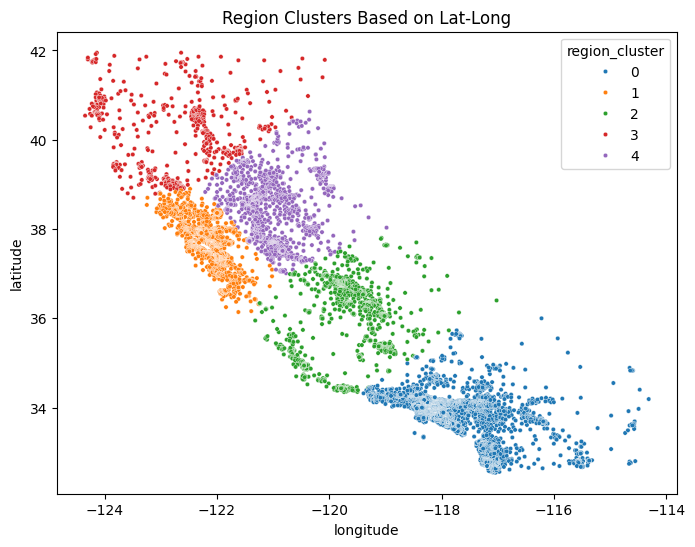

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='region_cluster', palette='tab10', s=10)
plt.title('Region Clusters Based on Lat-Long')
plt.show()

#### 4.1.Impute missing values

In [63]:
df['total_bedrooms'] = df.groupby('region_cluster')['total_bedrooms'].transform(lambda x: x.fillna(x.median()))
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
region_cluster        0
dtype: int64

#### 4.2. Feature Engineering

In [64]:
df['room_density'] = df['total_rooms'] / df['households']
df['bedroom_prop'] = df['total_bedrooms'] / df['total_rooms']
df['pop_density'] = df['population'] / df['households']

### 5.Log Transformation of Target for Normality

In [65]:
df['median_house_value'] = np.log1p(df['median_house_value'])

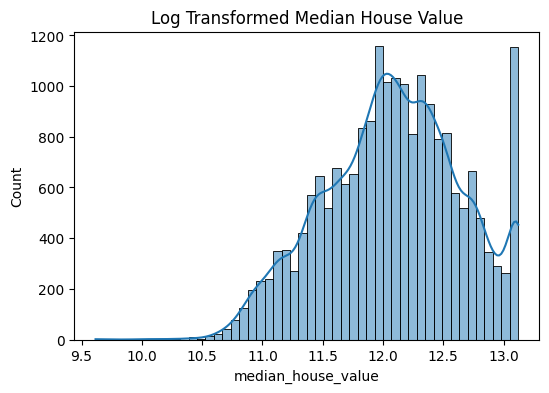

In [66]:
plt.figure(figsize=(6, 4))
sns.histplot(df['median_house_value'], bins=50, kde=True)
plt.title('Log Transformed Median House Value')
plt.show()

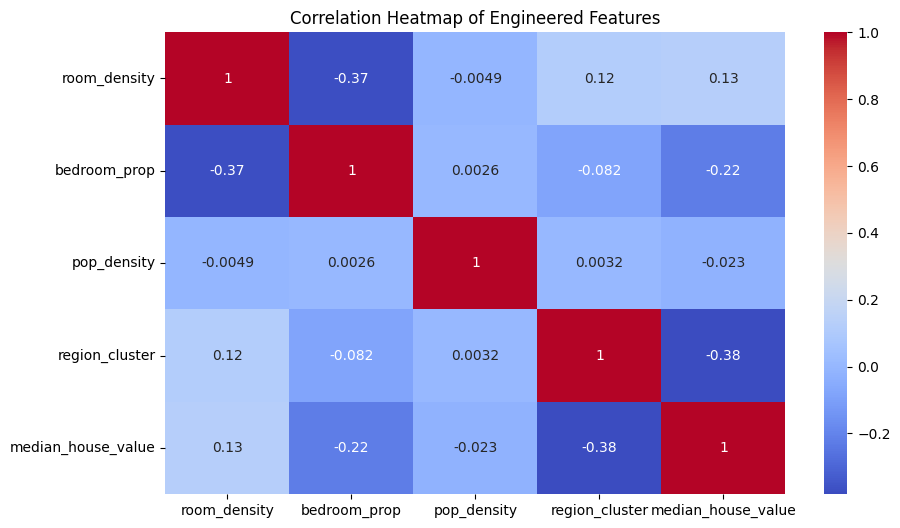

In [67]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['room_density', 'bedroom_prop', 'pop_density','region_cluster' ,'median_house_value']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

### 6.Drop Unused Columns

In [68]:
df = df.drop(['total_rooms', 'total_bedrooms'], axis=1)

### 7. Encode Categorical Columns

In [69]:

ocean_dummies = pd.get_dummies(df['ocean_proximity'], drop_first=True)
df = pd.concat([df, ocean_dummies], axis=1)
df = df.drop('ocean_proximity', axis=1)

In [70]:
region_dummies = pd.get_dummies(df['region_cluster'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)
df.drop('region_cluster', axis=1, inplace=True)

### 8. Define features for models

In [71]:
features_for_linear = ['median_income', 'bedroom_prop', 'pop_density', 
                       'room_density', 'housing_median_age','INLAND',
                       'ISLAND','NEAR BAY','NEAR OCEAN','region_1',
                       'region_2','region_3','region_4']
features_for_tree = ['longitude', 'latitude',
                     'housing_median_age', 'median_income',
                     'room_density', 'bedroom_prop', 'pop_density',
                     'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [72]:
features_for_tree

['longitude',
 'latitude',
 'housing_median_age',
 'median_income',
 'room_density',
 'bedroom_prop',
 'pop_density',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

### 9.Linear Regression 🔄

In [73]:
X_lr = df[features_for_linear]
y = df['median_house_value']
X_train_lr, X_test_lr, y_train, y_test = train_test_split(X_lr, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr)
X_test_scaled = scaler.transform(X_test_lr)

# VIF for Linear Regression
X_vif = sm.add_constant(pd.DataFrame(X_train_scaled, columns=X_lr.columns))
vif_data = pd.DataFrame()
vif_data["feature"] = X_lr.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X_lr.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))

# Train model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

               feature       VIF
5               INLAND  2.131672
0        median_income  2.095726
1         bedroom_prop  1.978200
7             NEAR BAY  1.881868
9             region_1  1.854323
12            region_4  1.640269
3         room_density  1.293475
10            region_2  1.290762
4   housing_median_age  1.160305
8           NEAR OCEAN  1.150105
11            region_3  1.132225
2          pop_density  1.003224
6               ISLAND  1.000863


LinearRegression()

### 10. Random Forest Regression

In [74]:
X_tree = df[features_for_tree]
y = df['median_house_value']
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_tree, y_train_tree)

RandomForestRegressor(random_state=42)

In [75]:
rf_importances = pd.DataFrame({'Feature': X_tree.columns, 'Importance': rf_model.feature_importances_})
print(rf_importances.sort_values(by='Importance', ascending=False))

               Feature  Importance
3        median_income    0.368062
7               INLAND    0.301780
6          pop_density    0.092194
1             latitude    0.074594
0            longitude    0.064887
2   housing_median_age    0.034467
5         bedroom_prop    0.032381
4         room_density    0.028962
10          NEAR OCEAN    0.001847
9             NEAR BAY    0.000794
8               ISLAND    0.000031


### 11. XGBoost Regressor

In [76]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=1, reg_lambda=1, random_state=42)
xgb_model.fit(X_train_tree, y_train_tree)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [77]:
xgb_importances = pd.DataFrame({'Feature': X_tree.columns, 'Importance': xgb_model.feature_importances_})
print(xgb_importances.sort_values(by='Importance', ascending=False))

               Feature  Importance
7               INLAND    0.760558
3        median_income    0.132677
6          pop_density    0.023909
5         bedroom_prop    0.018658
1             latitude    0.015021
0            longitude    0.013723
9             NEAR BAY    0.010831
10          NEAR OCEAN    0.008857
2   housing_median_age    0.008335
4         room_density    0.007433
8               ISLAND    0.000000


### 12.Evaluation

In [78]:

models = {
    'Linear Regression': (linear_model, X_test_scaled, X_train_scaled),
    'Random Forest': (rf_model, X_test_tree, X_train_tree),
    'XGBoost': (xgb_model, X_test_tree, X_train_tree)
}

def evaluate_model(name, model, X_test, X_train):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(f"\n{name} - Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f} R2: {r2_score(y_test, y_pred_test):.4f}")
    print(f"{name} - Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f} R2: {r2_score(y_train, y_pred_train):.4f}")

for name, (model, X_test, X_train) in models.items():
    evaluate_model(name, model, X_test, X_train)


Linear Regression - Test RMSE: 0.3491 R2: 0.6245
Linear Regression - Train RMSE: 0.3368 R2: 0.6496

Random Forest - Test RMSE: 0.2314 R2: 0.8350
Random Forest - Train RMSE: 0.0849 R2: 0.9777

XGBoost - Test RMSE: 0.2372 R2: 0.8267
XGBoost - Train RMSE: 0.2134 R2: 0.8593


In [79]:
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],           
    'max_depth': [10, 20, None],          
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

grid_rf = GridSearchCV(rf, param_grid_rf, scoring='neg_root_mean_squared_error',
                       cv=5, n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best Random Forest Parameters:", grid_rf.best_params_)

rf_preds = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
r2_rf = r2_score(y_test, rf_preds)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest RMSE: 0.22989292444244983
Random Forest R²: 0.8371625041340832


In [80]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],        
    'max_depth': [3, 6, 10],           
    'learning_rate': [0.01, 0.1, 0.3], 
    'subsample': [0.8, 1.0]            
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='neg_root_mean_squared_error',
                        cv=5, n_jobs=-1, verbose=1)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_xgb.best_params_)

xgb_preds = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
r2_xgb = r2_score(y_test, xgb_preds)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
XGBoost RMSE: 0.22261751970678248
XGBoost R²: 0.8473060307027896


## Summary

1. Data Loading and Exploration
1.1. Loaded the housing dataset and reviewed its shape, data types, and missing values.
1.2. Identified that the total_bedrooms column had missing values requiring imputation.

2. Spatial Feature Engineering
2.1. Applied KMeans clustering on latitude and longitude to generate a new region_cluster feature.
2.2. This helped encode spatial patterns more effectively than raw coordinates.

3. Imputation of Missing Values
3.1. Missing values in total_bedrooms were imputed using region-wise median.

4. Derived Feature Creation
4.1. Created ratio features:
4.1.1. room_density = total_rooms / households
4.1.2. bedroom_prop = total_bedrooms / total_rooms
4.1.3. pop_density = population / households


5. Target Variable Transformation
5.1. Applied logarithmic transformation on median_house_value to reduce skewness
5.2. Transformation improved model performance, particularly for linear models.

6. Encoding and Binning
6.1. Performed One-Hot Encoding on ocean_proximity and region_cluster (for linear regression).
6.2. Created regions of the cluster formed from lat-long (lat_bin, lon_bin).


7. Multicollinearity Handling (Linear Regression Only)
7.1. Used Variance Inflation Factor (VIF) to detect multicollinearity among linear regression features.
7.2. Removed variables with VIF > 5 (e.g., lat_bin, lon_bin) to improve model reliability.

8. Feature Selection for Tree Models
8.1. Removed features like population and households for tree models, as their signal was captured by pop_density.
8.2. Included either latitude/longitude or region dummies — not both — to prevent redundancy.
8.3. Relied on feature importances from Random Forest and XGBoost to validate top predictors.

9. Model Training and Evaluation
9.1. Trained the following models:

9.1.1. Linear Regression
9.1.2. Random Forest Regressor
9.1.3. XGBoost Regressor

9.3. Evaluated each model on both Train and Test sets using RMSE and R².

10. Results and Insights
10.1. Tree-based models (Random Forest and XGBoost) outperformed linear regression by a large margin.
10.2 Linear Regression tries to fit a straight line through the data, which doesn’t work well when the data has complex patterns or interactions. Tree-based models like Random Forest and XGBoost can understand these complicated patterns much better, which is why they gave more accurate results.
10.3 Tuned both Random Forest and XGBoost using grid search and 5-fold CV. While Random Forest showed marginal improvement, XGBoost benefitted more significantly from tuning. XGBoost reached an RMSE of 0.222 and R² of 0.847 the best among all models.